In [1]:
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Variable
import torch
import requests
import json
import numpy as np
from os import path
import os
import re
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms, utils

In [12]:
PATH = '/shared/HARRISON'
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
PLACES_FILE = '/shared/categories_places365.txt'

In [18]:
places_table = {}

with open(PLACES_FILE) as f:
    for line in f:
        (label, val) = line.strip().split(' ')
        places_table[int(val)] = label

places_table

{0: '/a/airfield',
 1: '/a/airplane_cabin',
 2: '/a/airport_terminal',
 3: '/a/alcove',
 4: '/a/alley',
 5: '/a/amphitheater',
 6: '/a/amusement_arcade',
 7: '/a/amusement_park',
 8: '/a/apartment_building/outdoor',
 9: '/a/aquarium',
 10: '/a/aqueduct',
 11: '/a/arcade',
 12: '/a/arch',
 13: '/a/archaelogical_excavation',
 14: '/a/archive',
 15: '/a/arena/hockey',
 16: '/a/arena/performance',
 17: '/a/arena/rodeo',
 18: '/a/army_base',
 19: '/a/art_gallery',
 20: '/a/art_school',
 21: '/a/art_studio',
 22: '/a/artists_loft',
 23: '/a/assembly_line',
 24: '/a/athletic_field/outdoor',
 25: '/a/atrium/public',
 26: '/a/attic',
 27: '/a/auditorium',
 28: '/a/auto_factory',
 29: '/a/auto_showroom',
 30: '/b/badlands',
 31: '/b/bakery/shop',
 32: '/b/balcony/exterior',
 33: '/b/balcony/interior',
 34: '/b/ball_pit',
 35: '/b/ballroom',
 36: '/b/bamboo_forest',
 37: '/b/bank_vault',
 38: '/b/banquet_hall',
 39: '/b/bar',
 40: '/b/barn',
 41: '/b/barndoor',
 42: '/b/baseball_field',
 43: '/b/

In [13]:
class_names = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [14]:
def map_classes(data):
    return [class_names[x] for x in data]

def map_places(data):
    return [places_table[x] for x in data]

In [2]:
arch = 'alexnet'

model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    print('Downloading file...')
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)


In [6]:
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load('alexnet_places365.pth.tar', map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
# state_dict = {re.sub(r'\.(\d{1,}\.)', r'\1', str.replace(k,'module.','')): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [7]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

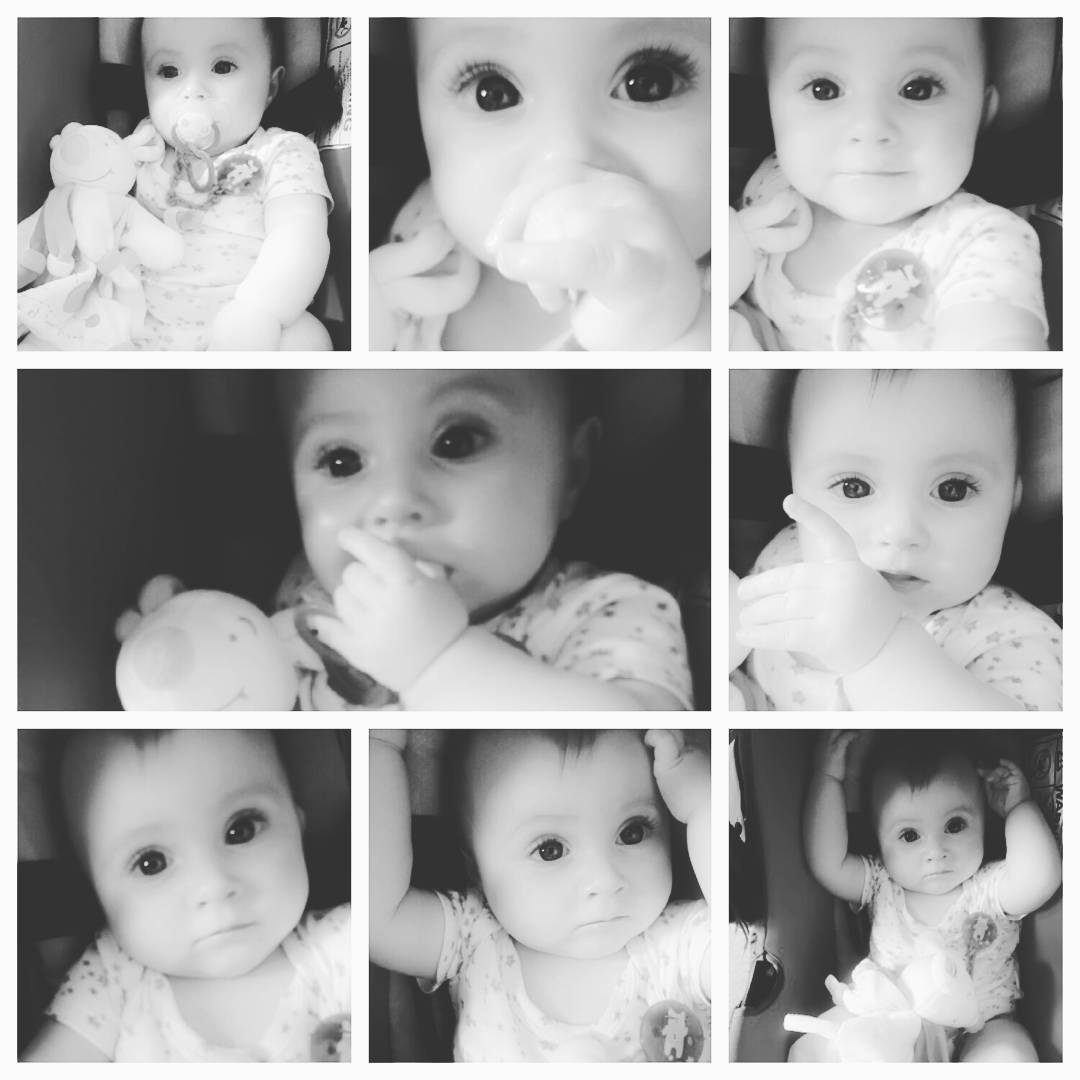

In [8]:
img_test = Image.open('/shared/HARRISON/instagram_dataset/loveyou/image_1125.jpg')
img_test

In [9]:
img_ten = preprocess(img_test)
img_ten.unsqueeze_(0)
img_variable = Variable(img_ten.cuda())

In [10]:
output_classes = model(img_variable) \
    .topk(5)[1] \
    .view(-1) \
    .tolist()

In [19]:
map_places(output_classes)

['/j/jewelry_shop',
 '/c/clean_room',
 '/h/hospital_room',
 '/p/physics_laboratory',
 '/r/restaurant_kitchen']